In [13]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense, Input, TimeDistributed, Masking
from keras.models import Model
import sys

random.seed(49297)

mimic3_path="/home/rafiparvez1706/mimic"
variable_map_file='../resources/itemid_to_variable_map.csv'
variable_ranges_file='../resources/variable_ranges.csv'
channel_info_file ='../resources/channel_info.json'
output_path ="../data/root"

In [14]:
train_dir = os.path.join(output_path, 'train')
train_id_dirs_orig = [os.path.join(train_dir, subdir) for subdir in os.listdir(train_dir)]

In [15]:
valid_dir = os.path.join(output_path, 'valid')
valid_id_dirs_orig = [os.path.join(valid_dir, subdir) for subdir in os.listdir(valid_dir)]

In [16]:
maxlen=0
lens=[]
train_id_dirs=train_id_dirs_orig[0:1000]
for cnt, folder in enumerate(train_id_dirs):
    Xfname = os.path.join(folder,'cleaned_timeseries.csv')
    df_X = pd.read_csv(Xfname)
    X_train=df_X.loc[:, df_X.columns != 'Hours'].values
    lens.append(X_train.shape[0])
    maxlen=max(maxlen,X_train.shape[0])
    
    
#maxlen=500
print(maxlen)

FileNotFoundError: File b'../data/root/train/218624/cleaned_timeseries.csv' does not exist

In [5]:
maxlen=200

## Preparing Sequential Data

In [6]:
def transform_data(folder,maxlen):
        Xfname = os.path.join(folder,'cleaned_timeseries.csv')
        df_X = pd.read_csv(Xfname)
        X_train=df_X.loc[:, df_X.columns != 'Hours'].values
        
        X_train = sequence.pad_sequences(X_train.T, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
        X_train=X_train.T
        X_train= X_train.reshape(1, X_train.shape[0],X_train.shape[1])
        
        
        X_train=X_train.astype(np.float32)
        
        yfname = os.path.join(folder,'stays.csv')
        
        df_y = pd.read_csv(yfname)
        IsReadmitted = df_y.IsReadmitted.values[0].astype(np.float32)
        y_train=np.empty(len(df_X))
        y_train.fill(IsReadmitted)
        y_train = y_train.astype(np.float32)
        y_train = [y_train]
        y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
        y_train=y_train.reshape(y_train.shape[0],y_train.shape[1],1)     
        
        return X_train,y_train

In [7]:
X_train,y_train=transform_data(train_id_dirs[0], maxlen)
X_train.shape

(1, 200, 58)

In [8]:
y_train.shape

(1, 200, 1)

## Defining Model

In [9]:
model = Sequential()
nb_samples=len(train_id_dirs)
input_dim=58

model.add(LSTM(output_dim=256, input_shape=(maxlen, 58), return_sequences=True))
model.add(Dropout(0.10))

model.add(LSTM(output_dim=128, return_sequences=True))
model.add(Dropout(0.10))

model.add(TimeDistributed(Dense(1, activation='sigmoid')))

optimizer=Adam(lr=0.001, beta_1=0.5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# print layer shapes and model parameters
model.summary()

/home/rafiparvez1706/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=256, input_shape=(200, 58))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200, 256)          322560    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 1)            257       
Total params: 322,817
Trainable params: 322,817
Non-trainable params: 0
_________________________________________________________________


In [10]:
train_id_dirs=random.sample(train_id_dirs_orig, 5000)
Total_count = len(train_id_dirs)

In [17]:
def generate_batches(files, batch_size):
    counter = 0
    while True:
        counter = (counter + 1) % len(files)
        folder = files[counter]
        X_train,y_train=transform_data(folder, maxlen)        

        for cbatch in range(0, X_train.shape[0], batch_size):
            yield (X_train[cbatch:(cbatch + batch_size),:,:], y_train[cbatch:(cbatch + batch_size)])
            
            
        for cbatch in range(0, X_train.shape[0], batch_size):
            yield (X_train[cbatch:(cbatch + batch_size),:,:], y_train[cbatch:(cbatch + batch_size)])


#train_files = [train_bundle_loc + "bundle_" + cb.__str__() for cb in range(nb_train_bundles)]
batch_size=8
samples_per_epoch=len(train_id_dirs)
num_epoch=4
gen = generate_batches(files=train_id_dirs, batch_size=batch_size)

history = model.fit_generator(gen, samples_per_epoch=samples_per_epoch, nb_epoch=num_epoch,verbose=1)

Epoch 1/1
   1/5000 [..............................] - ETA: 985s - loss: 0.0152 - acc: 1.0000

/home/rafiparvez1706/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/rafiparvez1706/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=5000, epochs=1)`


5000/5000 [==============================] - 883s - loss: 0.2048 - acc: 0.9327   


In [18]:
model.save_weights("lstm_model.h5")

## Model Evaluation

In [13]:
import pandas as pd
df = pd.DataFrame(train_id_dirs, columns=["trains"])
df.to_csv('train_id_dirs_3.csv', index=False)

In [21]:
cv_id_dirs=random.sample(valid_id_dirs_orig, 2000)
len(cv_id_dirs)

list_pred=[]
list_lbl=[]

for cv_folder in cv_id_dirs:
    X_cv, y_cv = transform_data(cv_folder, maxlen)
    preds = model.predict(X_cv)
    #print(preds[0][:20])
    label = y_cv[:, 0, :].squeeze();
    prediction = preds[:, -1, :].squeeze()
    #print(label,prediction)
    list_lbl.append(label)
    list_pred.append(prediction)

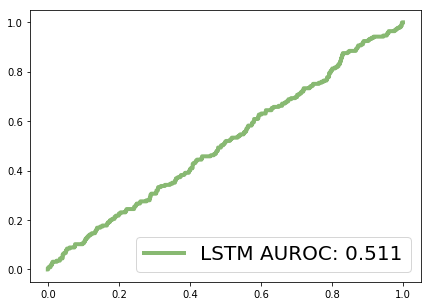

In [22]:
from sklearn.metrics import roc_curve, auc
# compute ROC curve for predictions
rnn_roc = roc_curve(list_lbl,list_pred)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(rnn_roc[0], rnn_roc[1], label='LSTM AUROC: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)